<a href="https://colab.research.google.com/github/rccrdmr/MAT422-Mathematics-for-DataScience/blob/main/3.5-6_K-Means_and_Support_Vector_Machine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 3.5 K-Means

K-means clustering is a popular vector quantization method that partitions $n$ observations into $k$ clusters. Each observation belongs to the cluster with the nearest mean (centroid), which serves as a prototype for the cluster. The method aims to minimize the within-cluster variances (squared Euclidean distances), but not regular Euclidean distances. While k-means general converge quickly to a local optimumm the problem is computationally difficult (NP-hard).
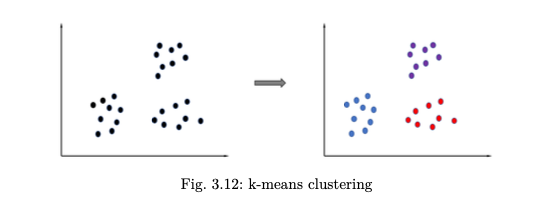


#### Objective Function

Given $ x_1, x_2, \ldots, x_n $ as $ d $-dimensional real vectors, K-means seeks to minimize the within-cluster sum of squares (WCSS):

$$
\text{WCSS}_i = \sum_{x \in S_i} \|x - \mu(S_i)\|^2,
$$

where $ \mu(S_i) $ is the mean of points in $ S_i $:

$$
\mu(S_i) = \frac{1}{|S_i|} \sum_{x \in S_i} x.
$$

The objective is:

$$
\arg \min_{S} \sum_{i=1}^{k} \text{WCSS}_i.
$$

#### K-means Clustering Algorithm:


1. Initialize $ k $ cluster centers randomly.
2. Assign each point to the nearest cluster center based on Euclidean distance.
3. Compute the centroid for each cluster.
4. Repeat steps 2 and 3 until no points change clusters between iterations.

In [42]:
def k_means(X, k, n_iter, seed=42):
    """
    K-Means clustering algorithm.

    Parameters:

      X: array-like, shape (n_samples, n_features) := Training data.
      k: int :=  Number of clusters.
      n_iter: int := Number of iterations.

    Return: tuple of clusters and centroids
    """
    np.random.seed(seed)
    n_samples, n_features = X.shape
    centroids = X[np.random.choice(n_samples, k, replace=False)]
    clusters = np.zeros(n_samples)

    for _ in range(n_iter):
        clusters = np.argmin(cdist(X, centroids), axis=1)
        for i in range(k):
            if len(X[clusters == i]) > 0:
                centroids[i] = np.mean(X[clusters == i], axis=0)

    return clusters, centroids

#### Convergence Proof

K-means converges because $ \sum_{i=1}^{k} \text{WCSS}_i $ decreases in each iteration:

- **Reassignment Step**: Each vector is assigned to the closest centroid, decreasing the total WCSS.
- **Recomputation Step**: The new centroid $ \mu(S_i) $ minimizes $ \text{WCSS}_i $.

The centroid $ v $ that minimizes $ \text{WCSS}_i $ is:

$$
v = \frac{1}{|S_i|} \sum_{x \in S_i} x.
$$

Hence, the objective $ \sum_{i=1}^{k} \text{WCSS}_i $ monotonically decreases, ensuring convergence.

#### Demo

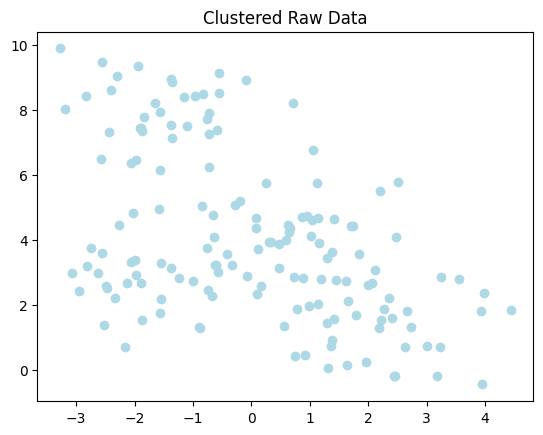

In [45]:
import numpy as np
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs

# Generate data with more samples and higher cluster standard deviation
X, y = make_blobs(n_samples=150, centers=4, n_features=2, random_state=0, cluster_std=1.0)

plt.scatter(X[:, 0], X[:, 1], color='lightblue', marker='o')
plt.title("Clustered Raw Data")
plt.show()

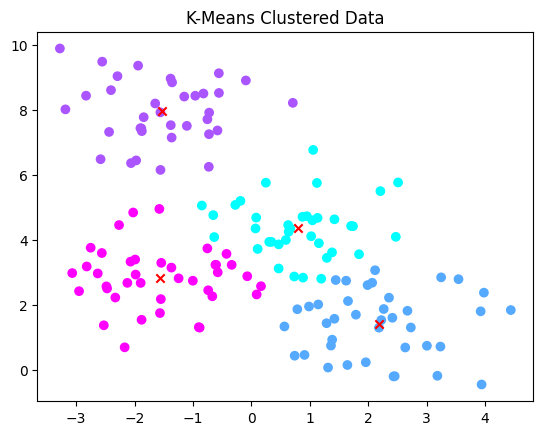

In [46]:
# Run K-Means
clusters, centroids = k_means(X, 4, 15)

plt.scatter(X[:, 0], X[:, 1], c=clusters, cmap='cool')
plt.scatter(centroids[:, 0], centroids[:, 1], marker='x', c='r')
plt.title("K-Means Clustered Data")
plt.show()

# 3.6 Support Vector Machine

Support-vector machines (SVMs) are supervised learning models used for classification and regression analysis. The goal is to find a hyperplane that separates data points of different classes with the maximum margin.


#### Problem Setup

Given a training dataset of $ n $ points of the form:

$$
(x_1, y_1), \ldots, (x_n, y_n),
$$

where $ y_i \in \{-1, 1\} $ indicates the class of point $ x_i $, and $ x_i $ is a $ p $-dimensional real vector. The objective is to find a hyperplane:

$$
w^T x - b = 0,
$$

where $ w $ is the normal vector to the hyperplane.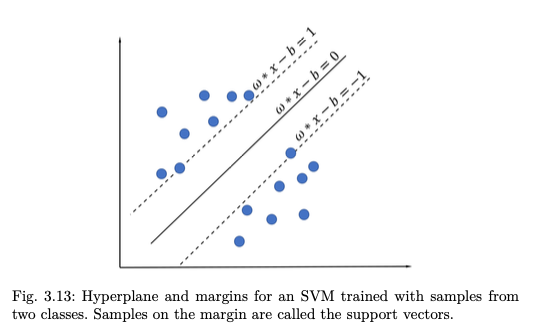

#### Margin and Constraints


For linearly separable data, select two parallel hyperplanes such that:

$$
w^T x - b = 1 \quad \text{and} \quad w^T x - b = -1.
$$

The margin is the distance between these two hyperplanes, and it should be maximized. We require:

- For $ y_i = 1 $: $ w^T x_i - b \geq 1 $.
- For $ y_i = -1 $: $ w^T x_i - b \leq -1 $.

These can be combined into:

$$
y_i (w^T x_i - b) \geq 1, \quad \text{for all } i.
$$

#### Optimization Problem

To maximize the margin, we minimize $ \|w\| $, subject to the constraints:

$$
\min_{w, b} \left\{ \lambda \|w\|^2 + \frac{1}{n} \sum_{i=1}^{n} \max\{0, 1 - y_i (w^T x_i - b)\} \right\},
$$

where $ \lambda $ is a regularization parameter.

In [47]:
def loss(X, y, w, b, l):
    """
    Loss function for linear SVMs.

    Parameters:

      X: array-like, shape (n_samples, n_features) := Training data.
      y: array-like, shape (n_samples,) := Target values.
      w: array-like, shape (n_features,) := Normal vector of the hyperplane.
      b: float := Bias of the hyperplane.
      l: float := Regularization parameter.

    Return: float

    """
    n_samples = X.shape[0]
    return l * np.linalg.norm(w) ** 2 + np.sum(np.maximum(0, 1 - y * (np.dot(X, w) + b))) / n_samples

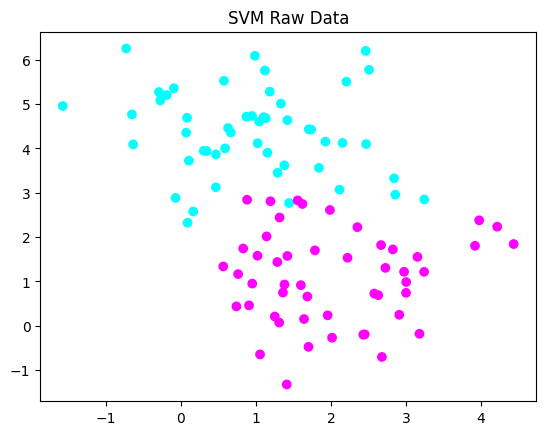

In [48]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs

# Generate data
X, y = make_blobs(n_samples=100, centers=2, n_features=2, random_state=0, cluster_std=1)

plt.scatter(X[:, 0], X[:, 1], c=y, cmap='cool')
plt.title("SVM Raw Data")
plt.show()

In [49]:
# Initialize weights, bias, and regularization parameter
w = np.array([1, 1])
b = 0
l = 1

# Calculate initial loss
print(f"Loss: {loss(X, y, w, b, l):0.4f}")

Loss: 2.5151


#### Gradient Descent Solution

The unconstrained optimization can be solved using gradient descent. The updates are defined as follows:

- Update $ b $:
  $$
  \text{New } b = \text{Old } b - \beta \times \left\{
  \begin{array}{ll}
  y_i, & \text{if } 1 - y_i (w^T x_i - b) > 0 \\
  0, & \text{otherwise}
  \end{array}
  \right.
  $$

- Update $ w $:
  $$
  \text{New } w = \text{Old } w - \beta \times \left\{
  \begin{array}{ll}
  2\lambda w - \frac{1}{n} y_i x_i, & \text{if } 1 - y_i (w^T x_i - b) > 0 \\
  2\lambda w, & \text{otherwise}
  \end{array}
  \right.
  $$


#### Key Points

- The optimization problem is convex with respect to $ w $, allowing gradient descent methods to find the minimum efficiently.
- The parameter $ \lambda $ controls the trade-off between maximizing the margin and minimizing classification errors.


#### Demo

In [50]:
from sklearn.svm import LinearSVC

# Fit an SVM model using scikit-learn
clf = LinearSVC()
clf.fit(X, y)

# Learned weights and intercept
print("Weights:", clf.coef_)
print("Intercept:", clf.intercept_)

Weights: [[ 0.21178321 -0.85715426]]
Intercept: [1.944494]


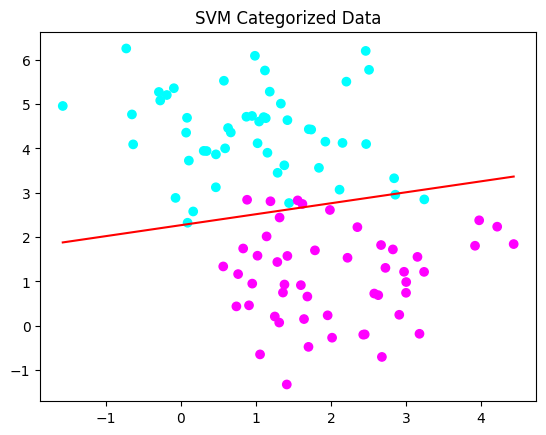

In [51]:
# SVM decision boundary
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='cool')
x_vals = np.linspace(min(X[:, 0]), max(X[:, 0]), 100)
y_vals = -(clf.coef_[0][0] * x_vals + clf.intercept_[0]) / clf.coef_[0][1]

plt.plot(x_vals, y_vals, color='red')
plt.title("SVM Categorized Data")
plt.show()